### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [194]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [211]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [212]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [213]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [150]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v0.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(46500, 41)

(4444, 41)

(4403, 41)

count    46500.000000
mean       167.403097
std         10.350122
min        149.000000
25%        159.000000
50%        168.000000
75%        176.000000
max        184.000000
Name: prd, dtype: float64

count    4444.000000
mean      185.997525
std         0.816079
min       185.000000
25%       185.000000
50%       186.000000
75%       187.000000
max       187.000000
Name: prd, dtype: float64

count    4403.000000
mean      188.997956
std         0.818208
min       188.000000
25%       188.000000
50%       189.000000
75%       190.000000
max       190.000000
Name: prd, dtype: float64

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (4444, 84) (4381, 84) (4403, 84)
mae of a constant model 7.707782488355303
R2 of a constant model 0.0
fixed XGB train: 7.153201360601873 0.07116040354151332
XGB val: 8.837832454907955 0.008860833991066297
XGB val extra: 7.211958123190973 0.0036993266374161227
XGB test: 10.277253411139476 0.03135074261835891
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} 0.010984067391343721 51.05036783218384
XGB train: 7.238038585013199 0.04442135756862975
XGB validation: 8.665303652164834 0.05698181575167449
XGB validation extra: 7.015380940639335 0.06510190636891111
XGB test: 10.293781281549693 0.025865666367645757


[I 2022-09-06 21:35:15,286] A new study created in memory with name: no-name-5fc2fc34-6e1e-4dc6-b422-0f7476d51047
[I 2022-09-06 21:35:16,635] Trial 0 finished with value: 0.0012920285579554047 and parameters: {'n_estimators': 1376, 'max_depth': 4, 'learning_rate': 0.012789215246487693, 'colsample_bytree': 0.6355143467934535, 'subsample': 0.5072585288686067, 'alpha': 2.67552498595899, 'lambda': 57.50655673297819, 'gamma': 2.423454826234995e-06, 'min_child_weight': 0.15551689060047094}. Best is trial 0 with value: 0.0012920285579554047.
[I 2022-09-06 21:35:18,210] Trial 1 finished with value: 0.0013823920153221755 and parameters: {'n_estimators': 1019, 'max_depth': 6, 'learning_rate': 0.025598116857956495, 'colsample_bytree': 0.09432854850096978, 'subsample': 0.6682072123239617, 'alpha': 1.751345863622901, 'lambda': 15.875375159879173, 'gamma': 1.0551369383196207, 'min_child_weight': 36.351140107857184}. Best is trial 1 with value: 0.0013823920153221755.
[I 2022-09-06 21:35:20,011] Trial

Total time for hypermarameter optimization  30.163309335708618
        n_estimators : 919
           max_depth : 2
       learning_rate : 0.017887947404402794
    colsample_bytree : 0.7647654057694923
           subsample : 0.7650978363135915
               alpha : 0.6604227266527427
              lambda : 0.36644525166701475
               gamma : 0.000358111670683785
    min_child_weight : 17.968404377574277
best objective value : 0.007201674191538943
Optuna XGB train: 
 7.259029341925926 0.03384663439728741 
validation 
 8.674986716477399 0.04865068017421925 7.2227155499822135 -0.0008894694902390476 
test 
 10.30235048820971 0.025893714298076187


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07116,0.008861,0.031351,0.044421,0.056982,0.025866,0.033847,0.048651,0.025894


In [198]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train     0.053382
xgbf_val       0.008023
xgbf_test      0.008769
xgbgs_train    0.029245
xgbgs_val      0.043444
xgbgs_test     0.007270
xgbo_train     0.036133
xgbo_val       0.054458
xgbo_test      0.006025
dtype: float64

633.7301712036133


In [ ]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [ ]:
optuna_xgb

In [ ]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [ ]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


In [ ]:
print('Total time for a script: ', time.time()-time0)

In [ ]:
results.iloc[:,1:].mean()

In [ ]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [ ]:
display(X_train, X_val, X_test)

In [ ]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

In [ ]:
neurons_base = 4
dropout_rate = 0.01

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

In [240]:
neurons_base = 32
l2_reg_rate = 0.2

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

65665


Epoch 1/1000
23/23 - 1s - loss: 186.2213 - mean_squared_error: 99.6393 - val_loss: 209.2541 - val_mean_squared_error: 137.8215
Epoch 2/1000
23/23 - 0s - loss: 159.5781 - mean_squared_error: 99.0751 - val_loss: 187.3236 - val_mean_squared_error: 137.6768
Epoch 3/1000
23/23 - 0s - loss: 141.1014 - mean_squared_error: 99.0143 - val_loss: 172.3707 - val_mean_squared_error: 137.7165
Epoch 4/1000
23/23 - 0s - loss: 128.5203 - mean_squared_error: 98.9902 - val_loss: 162.0690 - val_mean_squared_error: 137.5974
Epoch 5/1000
23/23 - 0s - loss: 120.0193 - mean_squared_error: 99.0399 - val_loss: 155.9344 - val_mean_squared_error: 138.4511
Epoch 6/1000
23/23 - 0s - loss: 114.1460 - mean_squared_error: 99.0362 - val_loss: 149.9845 - val_mean_squared_error: 137.2420
Epoch 7/1000
23/23 - 0s - loss: 110.0857 - mean_squared_error: 99.0374 - val_loss: 147.8445 - val_mean_squared_error: 138.4294
Epoch 8/1000
23/23 - 0s - loss: 107.2931 - mean_squared_error: 99.0517 - val_loss: 145.0645 - val_mean_squared_

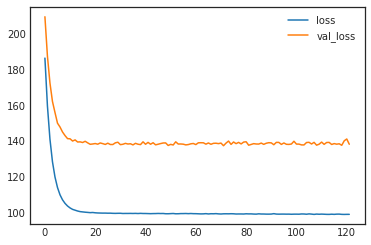

In [241]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [ ]:
X_train.skew()

In [ ]:
X_val

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# classic architecture:

neurons_base = 32
l2_reg_rate = 0.5
he_init = tf.keras.initializers.HeNormal()

model_nn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="elu", kernel_initializer=he_init, 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=neurons_base*4, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base*2, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(units=neurons_base, activation="elu", kernel_initializer=he_init,
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(1)])

print(model_nn.count_params())


In [ ]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_nn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_nn.predict(X_train)), 
       r2_score(y_val, model_nn.predict(X_val)),
       r2_score(y_test, model_nn.predict(X_test))])
print(time.time()-time1)